In [61]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
from docplex.mp.model import Model

## Loading Davidson county map

In [73]:
gdf_county = gpd.read_file("county.zip")

<AxesSubplot:>

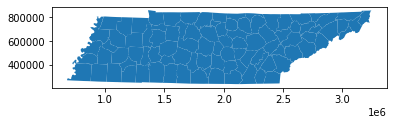

In [74]:
gdf_county.plot()

In [75]:
gdf_dav = gdf_county[gdf_county["COUNTY"] == "Davidson"]

In [76]:
gdf_dav.head()

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry
30,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1725320.674 734952.517, 1725410.826 ..."
49,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((1814456.873 657102.349, 1813945.726 ..."


In [77]:
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# P-median

In [150]:
preds = pd.read_csv('prediction_results.csv')

In [151]:
truths = pd.read_csv('true_results.csv')

In [153]:
preds = preds.sort_values(by=['xd_id'], ascending=False)
truths = truths.sort_values(by=['xd_id'], ascending=False)

In [154]:
preds['xd_id'].drop_duplicates().shape
truths['xd_id'].drop_duplicates().shape

(8073,)

In [155]:
roads = gpd.read_file('USA_Tennessee.geojson')

In [157]:
roads = roads[roads['County']=='DAVIDSON']

In [158]:
preds = preds[preds.xd_id.isin(roads.XDSegID)]
truths = truths[truths.xd_id.isin(roads.XDSegID)]

In [159]:
preds_geom = preds.merge(roads[['XDSegID', 'geometry']], how = 'left', left_on='xd_id', right_on = 'XDSegID')
truths_geom = truths.merge(roads[['XDSegID', 'geometry']], how = 'left', left_on='xd_id', right_on = 'XDSegID')

In [207]:
preds_geom.reset_index()
truths_geom.reset_index()

,index,xd_id,sum(label),XDSegID,geometry
0,0,1524646899,0.0,1524646899,"LINESTRING (-86.70474 36.12184, -86.70476 36.1..."
1,1,1524646417,0.0,1524646417,"LINESTRING (-86.79180 36.15885, -86.79144 36.1..."
2,2,1524646416,0.0,1524646416,"LINESTRING (-86.79372 36.16328, -86.79372 36.1..."
3,3,1524645372,0.0,1524645372,"LINESTRING (-86.74435 36.14281, -86.74437 36.1..."
4,4,1524644585,2.0,1524644585,"LINESTRING (-86.84079 36.15400, -86.84201 36.1..."
...,...,...,...,...,...
7994,7994,155742183,0.0,155742183,"LINESTRING (-86.79645 36.23706, -86.79650 36.2..."
7995,7995,155730113,0.0,155730113,"LINESTRING (-86.71250 36.32843, -86.71272 36.3..."
7996,7996,155725149,0.0,155725149,"LINESTRING (-86.75020 36.15446, -86.75019 36.1..."
7997,7997,155716829,0.0,155716829,"LINESTRING (-86.77935 36.03619, -86.77935 36.0..."


# Prediction data

In [161]:
preds_geom_dropped_zeros = preds_geom[preds_geom['sum(prediction)'] != 0].reset_index()

In [162]:
arr_roads = pd.Series.tolist(preds_geom_dropped_zeros.index)
arr_incs = pd.Series.tolist(preds_geom_dropped_zeros['sum(prediction)'])
# print(arr_grids)

In [163]:
roads_len = preds_geom_dropped_zeros.shape[0]
roads_len

748

In [164]:
dav_roads_dist = preds_geom_dropped_zeros
dist_mat = [[] for i in range(roads_len)]

for i in range(0, roads_len):
  p1 = dav_roads_dist.geometry.iloc[i]
  for j in range(roads_len):
    p2 = dav_roads_dist.geometry.iloc[j]
    dist_mat[i].append(round(p1.distance(p2), 2))

# print(dist_mat)

# the p-median optimizer

In [165]:

tm = Model(name='distribution')

emr = arr_roads
roads = arr_roads
max_emrP = 3
demand = arr_incs
distance = dist_mat
emr_loc = tm.binary_var_list(len(emr), 0, 1, "emr")
# open_loc = {(i): tm.binary_var(name='loc_{0}'.format(s)) for s in emr}
# print(open_loc)
assign = [[tm.binary_var("assign_{0}_{1}".format(i, j)) for j in range(len(roads))]  for i in range(len(emr))]
# assign = {(i,j): tm.binary_var(name='assign_{0}_{1}'.format(s,g)) for s in emr for g in roads}
# print(len(assign))
# each arc comes with a cost. Minimize all costed flows

tm.print_information()

for r in roads:
    # print("g=", g)
    tm.add_constraint(tm.sum(assign[e][r] for e in emr) == 1)
    
tm.add_constraint(tm.sum(emr_loc[e] for e in emr) == max_emrP)
    
for e in emr:
    for r in roads:
        tm.add_constraint(assign[e][r] <= emr_loc[e])
        
tm.minimize(tm.sum(distance[e][r]*demand[r]*assign[e][r] for e in range(len(emr)) for r in range(len(roads))))
url = None
key = None
tms = tm.solve(url=url, key=key)
assert tms
tms.display()

Model: distribution
 - number of variables: 560252
   - binary=560252, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP
solution for: distribution
objective: 82.980
emr_12 = 1
emr_193 = 1
emr_378 = 1
assign_12_0 = 1
assign_12_1 = 1
assign_12_3 = 1
assign_12_5 = 1
assign_12_6 = 1
assign_12_11 = 1
assign_12_12 = 1
assign_12_13 = 1
assign_12_14 = 1
assign_12_15 = 1
assign_12_16 = 1
assign_12_24 = 1
assign_12_27 = 1
assign_12_28 = 1
assign_12_30 = 1
assign_12_45 = 1
assign_12_47 = 1
assign_12_49 = 1
assign_12_50 = 1
assign_12_53 = 1
assign_12_64 = 1
assign_12_65 = 1
assign_12_68 = 1
assign_12_72 = 1
assign_12_73 = 1
assign_12_74 = 1
assign_12_75 = 1
assign_12_76 = 1
assign_12_96 = 1
assign_12_99 = 1
assign_12_100 = 1
assign_12_104 = 1
assign_12_105 = 1
assign_12_108 = 1
assign_12_114 = 1
assign_12_115 = 1
assign_12_116 = 1
assign_12_117 = 1
assign_12_118 = 1
assign_12_121 = 1
assign_12_135 = 1
assign_12_13

In [169]:
locs = []
assignments  = [[], [], []]
count = 0
for i in range(len(emr_loc)):
    if (emr_loc[i].solution_value == 1):
        locs.append(i)
        for j in range(len(roads)):
            if (assign[i][j].solution_value == 1):
                assignments[count].append(j) 
        count+=1
    

In [170]:
preds_geom_dropped_zeros_gdf = gpd.GeoDataFrame(preds_geom_dropped_zeros, geometry=preds_geom_dropped_zeros.geometry)

## Predicted EMR and their coverage area plots

<AxesSubplot:>

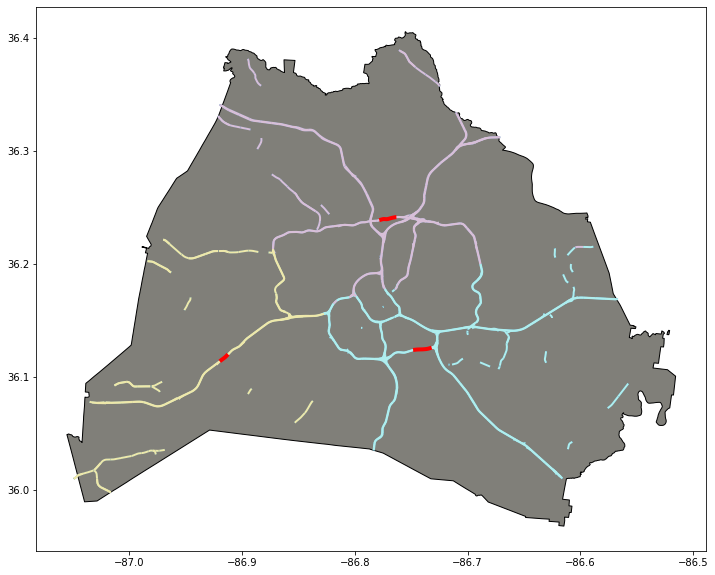

In [181]:
# dav_grids3 = dav_grids2
dax = preds_geom_dropped_zeros_gdf.plot(figsize=(12, 12))
gdf_david.plot(ax = dax, color = '#807f79', edgecolor='black')
# preds_geom_dropped_zeros_gdf.plot(ax = dax, color='white')
for i in assignments[0]:
    preds_geom_dropped_zeros_gdf[preds_geom_dropped_zeros_gdf.index == i].plot(ax = dax, linewidth=2, color='paleturquoise', legend=True)
for i in assignments[1]:
    preds_geom_dropped_zeros_gdf[preds_geom_dropped_zeros_gdf.index == i].plot(ax = dax, linewidth=2, color='thistle', legend=True)
for i in assignments[2]:
    preds_geom_dropped_zeros_gdf[preds_geom_dropped_zeros_gdf.index == i].plot(ax = dax, linewidth=2, color='palegoldenrod', legend=True)
preds_geom_dropped_zeros_gdf[preds_geom_dropped_zeros_gdf.index == locs[0]].plot(ax = dax, linewidth=4, color='red')
preds_geom_dropped_zeros_gdf[preds_geom_dropped_zeros_gdf.index == locs[1]].plot(ax = dax, linewidth=4, color='red')
preds_geom_dropped_zeros_gdf[preds_geom_dropped_zeros_gdf.index == locs[2]].plot(ax = dax, linewidth=4, color='red')

In [90]:
# dax = preds_geom_dropped_zeros_gdf.plot(figsize=(12, 12))
# gdf_david.plot(ax = dax, color = '#807f79', edgecolor='black')
# preds_geom_dropped_zeros_gdf.plot(ax = dax, color='white')

# Ground Truth data

In [202]:
truths_geom_dropped_zeros = truths_geom[truths_geom['sum(label)'] != 0].reset_index()

In [203]:
roads_len = truths_geom_dropped_zeros.shape[0]
roads_len

182

In [204]:
arr_grids = pd.Series.tolist(truths_geom_dropped_zeros.index)
arr_incs = pd.Series.tolist(truths_geom_dropped_zeros['sum(label)'])
# print(arr_grids)

In [205]:
#truths
dav_roads_dist = truths_geom_dropped_zeros
dist_mat = [[] for i in range(roads_len)]

for i in range(0, roads_len):
  p1 = dav_roads_dist.geometry.iloc[i]
  for j in range(roads_len):
    p2 = dav_roads_dist.geometry.iloc[j]
    dist_mat[i].append(round(p1.distance(p2), 2))

# print(dist_mat)

In [206]:
#p-median optimizer
tm = Model(name='distribution')

sheds = arr_grids
grids = arr_grids
max_shedsP = 3
demand = arr_incs
distance = dist_mat
shed_loc = tm.binary_var_list(len(sheds), 0, 1, "shed")
# open_loc = {(i): tm.binary_var(name='loc_{0}'.format(s)) for s in sheds}
# print(open_loc)
assign = [[tm.binary_var("assign_{0}_{1}".format(i, j)) for j in range(len(grids))]  for i in range(len(sheds))]
# assign = {(i,j): tm.binary_var(name='assign_{0}_{1}'.format(s,g)) for s in sheds for g in grids}
# print(len(assign))
# each arc comes with a cost. Minimize all costed flows

tm.print_information()

for g in grids:
    # print("g=", g)
    tm.add_constraint(tm.sum(assign[s][g] for s in sheds) == 1)
    
tm.add_constraint(tm.sum(shed_loc[s] for s in sheds) == max_shedsP)
    
for s in sheds:
    for g in grids:
        tm.add_constraint(assign[s][g] <= shed_loc[s])
        
tm.minimize(tm.sum(distance[s][g]*demand[g]*assign[s][g] for s in range(len(sheds)) for g in range(len(grids))))
url = None
key = None
tms = tm.solve(url=url, key=key)
assert tms
tms.display()

Model: distribution
 - number of variables: 33306
   - binary=33306, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP
solution for: distribution
objective: 19.740
shed_6 = 1
shed_73 = 1
shed_134 = 1
assign_6_5 = 1
assign_6_6 = 1
assign_6_7 = 1
assign_6_8 = 1
assign_6_10 = 1
assign_6_13 = 1
assign_6_15 = 1
assign_6_17 = 1
assign_6_18 = 1
assign_6_19 = 1
assign_6_23 = 1
assign_6_31 = 1
assign_6_32 = 1
assign_6_33 = 1
assign_6_34 = 1
assign_6_35 = 1
assign_6_36 = 1
assign_6_37 = 1
assign_6_39 = 1
assign_6_41 = 1
assign_6_44 = 1
assign_6_45 = 1
assign_6_46 = 1
assign_6_47 = 1
assign_6_51 = 1
assign_6_52 = 1
assign_6_56 = 1
assign_6_57 = 1
assign_6_58 = 1
assign_6_59 = 1
assign_6_60 = 1
assign_6_61 = 1
assign_6_62 = 1
assign_6_64 = 1
assign_6_65 = 1
assign_6_67 = 1
assign_6_71 = 1
assign_6_72 = 1
assign_6_74 = 1
assign_6_75 = 1
assign_6_76 = 1
assign_6_77 = 1
assign_6_82 = 1
assign_6_83 = 1
assign_6_85 = 1


In [114]:
locs = []
assignments  = [[], [], []]
count = 0
for i in range(len(shed_loc)):
    if (shed_loc[i].solution_value == 1):
        locs.append(i)
        for j in range(len(grids)):
            if (assign[i][j].solution_value == 1):
                assignments[count].append(j) 
        count+=1
    

In [115]:
truths_geom_dropped_zeros_gdf = gpd.GeoDataFrame(truths_geom_dropped_zeros, geometry=truths_geom_dropped_zeros.geometry)

## Ground truth plot

<AxesSubplot:>

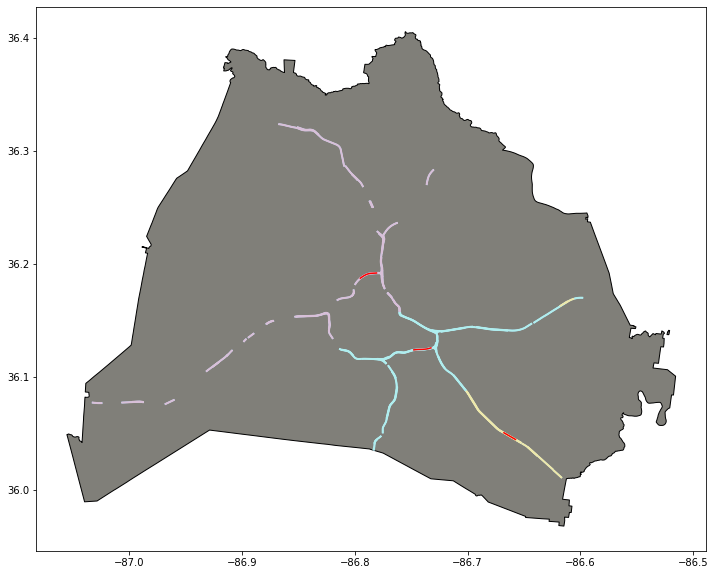

In [116]:
# dav_grids3 = dav_grids2
dax = truths_geom_dropped_zeros_gdf.plot(figsize=(12, 12))
gdf_david.plot(ax = dax, color = '#807f79', edgecolor='black')
truths_geom_dropped_zeros_gdf.plot(ax = dax, color='white')

for i in assignments[0]:
    truths_geom_dropped_zeros_gdf[truths_geom_dropped_zeros_gdf.index == i].plot(ax = dax, linewidth=2, color='paleturquoise')
for i in assignments[1]:
    truths_geom_dropped_zeros_gdf[truths_geom_dropped_zeros_gdf.index == i].plot(ax = dax, linewidth=2, color='thistle')
for i in assignments[2]:
    truths_geom_dropped_zeros_gdf[truths_geom_dropped_zeros_gdf.index == i].plot(ax = dax, linewidth=2, color='palegoldenrod')
truths_geom_dropped_zeros_gdf[truths_geom_dropped_zeros_gdf.index == locs[0]].plot(ax = dax, color='red')
truths_geom_dropped_zeros_gdf[truths_geom_dropped_zeros_gdf.index == locs[1]].plot(ax = dax, color='red')
truths_geom_dropped_zeros_gdf[truths_geom_dropped_zeros_gdf.index == locs[2]].plot(ax = dax, color='red')